In [1]:
import numpy as np
import pySurrogate as pySur
import random
from matplotlib import pyplot as plt
%matplotlib inline

## Simple example of a parametrized complex exponential using a DataModeler

**Note**: Do not commit this notebook with changes to test values or parameters. It is used as a regression test in test_simple_surrogate. 

Run this code with 

```python
np.random.seed(0)
random.seed(0)
```

to reproduce the regression test. Note that the random package is used in cross-validation fits as its thread safe.

Creating a complex128 pySur RB/EI from 20 data sets with tol 0.0002 for Complex exponential surrogate
...got 7 basis elements
Complex exponential surrogate is fitting 7 nodes
Max training space LInf error: 0.010929279252002898
Max validation Full LInf error: 0.011180579970441628
Max validation Full RMS error: 0.005361021044922671
Max validation EI LInf error: 0.0009330051963177447
Max validation EI RMS error: 0.0003329715531560501
Max validation RB LInf error: 0.0005528477050509522
Max validation RB RMS error: 0.00019521431993762783


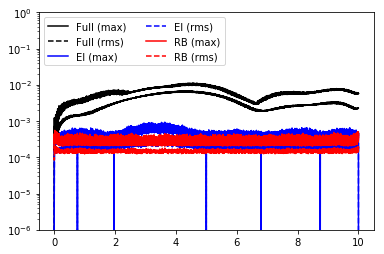


 ### Reducing cutoff ###
Complex exponential surrogate is fitting 7 nodes
Max training space Full LInf error: 0.001349600759153444
Max training space Full RMS error: 0.0006078317730841694
Max training space EI LInf error: 0.0006611741847233724
Max training space EI RMS error: 0.00026572172923344285
Max training space RB LInf error: 0.0005251774569605884
Max training space RB RMS error: 0.00019147604447071633
Max validation Full LInf error: 0.0020887339688757875
Max validation Full RMS error: 0.0008671113729539036
Max validation EI LInf error: 0.0009330051963177447
Max validation EI RMS error: 0.0003329715531560501
Max validation RB LInf error: 0.0005528477050509522
Max validation RB RMS error: 0.00019521431993762783



 ### Reducing cutoff too far ###
Complex exponential surrogate is fitting 7 nodes
Max training space Full LInf error: 0.0006611741847232782
Max training space Full RMS error: 0.00026572172923343027
Max training space EI LInf error: 0.0006611741847233724
Max training space EI RMS error: 0.00026572172923344285
Max training space RB LInf error: 0.0005251774569605884
Max training space RB RMS error: 0.00019147604447071633
Max validation Full LInf error: 0.26427574764203515
Max validation Full RMS error: 0.1578467356572924
Max validation EI LInf error: 0.0009330051963177447
Max validation EI RMS error: 0.0003329715531560501
Max validation RB LInf error: 0.0005528477050509522
Max validation RB RMS error: 0.00019521431993762783


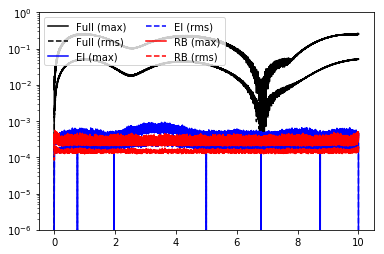

In [2]:
#np.random.seed(0)
#random.seed(0)

noiseLevel = 1.e-4

def f(w, t):
    return np.exp(1.j*w*t) + noiseLevel*np.exp(1000.j*w*w*t)

# Setup the domain
tMin = 0.
tMax = 10.
nDomain = 10000
times = np.linspace(tMin, tMax, nDomain)

# Setup the training space
wMin = 1.
wMax = 2.
nTS = 20
ts = np.linspace(wMin, wMax, nTS)

# Make a DataModeler object as our surrogate
sur = pySur.DataModeler(times, "Complex exponential surrogate")

# Add the data
for w in ts:
    sur.addKnownDataSet(np.array([w]), f(w, times))
    
# Build a reduced basis and empirical interpolant
sur.createEmpiricalInterpolant(basisTol=noiseLevel*2)

# Setup fits - these options will be remembered for all fits unless we override them
sur.setupFits(minVals=wMin, maxVals=wMax, absTol=1.e-2)

# Fit the data
sur.fit()

# That's it!  We can try evaluating the surrogate at the training points:
maxErr = 0.
for w in ts:
    exact_sol = f(w, times)
    sur_eval = sur(np.array([w]))
    maxErr = max(maxErr, max(abs(exact_sol - sur_eval)))
print 'Max training space LInf error: %s'%maxErr

# And of course we can evaluate the surrogate at other points too!
# Let's use the surrogate's test function to keep track of the errors for us:
validationSpace = np.linspace(wMin, wMax, nTS*10)
for w in validationSpace:
    exact_sol = f(w, times)
    test_evals = sur.test(np.array([w]), exact_sol)

colors = {'Full': 'k', 'RB': 'r', 'EI': 'b'}
for errType, errDict in sur.testErrors.iteritems():
    for k in ['LInf', 'RMS']:
        print 'Max validation %s %s error: %s'%(errType, k, max(errDict[k]))
    plt.semilogy(times, errDict['maxErrVsDomain'], colors[errType], label='%s (max)'%errType)
    plt.semilogy(times, errDict['rmsErrVsDomain'], colors[errType] + '--', label='%s (rms)'%errType)
plt.legend(loc='upper left', ncol=2)
plt.ylim((1.e-6, 1.))
plt.show()

# Maybe we want smaller errors.  Let's fit with a smaller cutoff:
print '\n ### Reducing cutoff ###'
sur.clearCheckedErrors()
sur.fit(absTol=1.e-3)
for w in ts:
    exact_sol = f(w, times)
    test_evals = sur.test(np.array([w]), exact_sol)
for errType, errDict in sur.testErrors.iteritems():
    for k in ['LInf', 'RMS']:
        print 'Max training space %s %s error: %s'%(errType, k, max(errDict[k]))
sur.clearCheckedErrors()
for w in validationSpace:
    exact_sol = f(w, times)
    test_evals = sur.test(np.array([w]), exact_sol)
for errType, errDict in sur.testErrors.iteritems():
    for k in ['LInf', 'RMS']:
        print 'Max validation %s %s error: %s'%(errType, k, max(errDict[k]))
    plt.semilogy(times, errDict['maxErrVsDomain'], colors[errType], label='%s (max)'%errType)
    plt.semilogy(times, errDict['rmsErrVsDomain'], colors[errType] + '--', label='%s (rms)'%errType)
plt.legend(loc='upper left', ncol=2)
plt.ylim((1.e-6, 1.))
plt.show()

# We better not go below the noise:
print '\n ### Reducing cutoff too far ###'
sur.clearCheckedErrors()
sur.fit(absTol=1.e-10)
for w in ts:
    exact_sol = f(w, times)
    test_evals = sur.test(np.array([w]), exact_sol)
for errType, errDict in sur.testErrors.iteritems():
    for k in ['LInf', 'RMS']:
        print 'Max training space %s %s error: %s'%(errType, k, max(errDict[k]))
sur.clearCheckedErrors()
for w in validationSpace:
    exact_sol = f(w, times)
    test_evals = sur.test(np.array([w]), exact_sol)
for errType, errDict in sur.testErrors.iteritems():
    for k in ['LInf', 'RMS']:
        print 'Max validation %s %s error: %s'%(errType, k, max(errDict[k]))
    plt.semilogy(times, errDict['maxErrVsDomain'], colors[errType], label='%s (max)'%errType)
    plt.semilogy(times, errDict['rmsErrVsDomain'], colors[errType] + '--', label='%s (rms)'%errType)
plt.legend(loc='upper left', ncol=2)
plt.ylim((1.e-6, 1.))
plt.show()

## Simple example of a parametrized complex exponential using DataGroup to model the real/imaginary parts

**Note**: Do not commit this notebook with changes to test values or parameters. It is used as a regression test in test_DataGroup_simple_surrogate. 

Run this code with 

```python
np.random.seed(0)
random.seed(0)
```

to reproduce the regression test. These two seed-reset lines appear multiple times throught the notebook. Note that the random package is used in cross-validation fits as its thread safe

In [3]:
#np.random.seed(0)
#random.seed(0)

# Setup the complex -> real/imag decomposition
class reImDG(pySur.DataGroup):
    def _decomposeSelf(self):
        self.dataPieces.append(pySur.DataModeler(self.domain, self.name + '_re',
                numericsHandler=self.nh))
        self.dataPieces.append(pySur.DataModeler(self.domain, self.name + '_im',
                numericsHandler=self.nh))

    def decomposeData(self, data):
        return [np.real(data), np.imag(data)]

    def combineData(self, pieces):
        return pieces[0] + 1.j*pieces[1]

    def errVsDomain(self, data, prediction):
        return abs(data - prediction)

    # Let's also add a normalized L1 error:
    def clearCheckedErrors(self, recursive=1):
        pySur.DataGroup.clearCheckedErrors(self, recursive)
        for errType, errDict in self.testErrors.iteritems():
            errDict['normL1'] = np.array([])

    def _recordErrors(self, x, data, prediction, key):
        pySur.dataHolder.DataHolder._recordErrors(self, x, data, prediction, key)
        err = np.sum(abs(data - prediction))/np.sum(abs(data))
        if len(self.testErrors[key]['normL1']) == 0:
            self.testErrors[key]['normL1'] = np.array([err])
        else:
            self.testErrors[key]['normL1'] = np.append(self.testErrors[key]['normL1'], err)

# Make our surrogate a reImDG object:
sur = reImDG(times, "re/im surrogate")

# Add the data
for w in ts:
    sur.addKnownDataSet(np.array([w]), f(w, times))
    
# Build a reduced basis and empirical interpolant
sur.createEmpiricalInterpolant(basisTol=noiseLevel*2)

# Fit the data
sur.fit(minVals=wMin, maxVals=wMax, absTol=1.e-2)

# Check the surrogate
for w in ts:
    exact_sol = f(w, times)
    test_evals = sur.test(np.array([w]), exact_sol)
for errType, errDict in sur.testErrors.iteritems():
    for k in ['LInf', 'RMS', 'normL1']:
        print 'Max training space %s %s error: %s'%(errType, k, max(errDict[k]))
sur.clearCheckedErrors()
for w in validationSpace:
    exact_sol = f(w, times)
    test_evals = sur.test(np.array([w]), exact_sol)
for errType, errDict in sur.testErrors.iteritems():
    for k in ['LInf', 'RMS', 'normL1']:
        print 'Max validation %s %s error: %s'%(errType, k, max(errDict[k]))


Creating a float64 pySur RB/EI from 20 data sets with tol 0.0002 for re/im surrogate_re
...got 9 basis elements
Creating a float64 pySur RB/EI from 20 data sets with tol 0.0002 for re/im surrogate_im
...got 9 basis elements
Fitting 18 functions with 1 procs...
Starting re/im surrogate_re_node0_idx0 fit with 20 data points...
...got 1 coefs for re/im surrogate_re_node0_idx0
Starting re/im surrogate_re_node1_idx3171 fit with 20 data points...
...got 4 coefs for re/im surrogate_re_node1_idx3171
Starting re/im surrogate_re_node2_idx6294 fit with 20 data points...
...got 6 coefs for re/im surrogate_re_node2_idx6294
Starting re/im surrogate_re_node3_idx9413 fit with 20 data points...
...got 8 coefs for re/im surrogate_re_node3_idx9413
Starting re/im surrogate_re_node4_idx9999 fit with 20 data points...
...got 9 coefs for re/im surrogate_re_node4_idx9999
Starting re/im surrogate_re_node5_idx7383 fit with 20 data points...
...got 7 coefs for re/im surrogate_re_node5_idx7383
Starting re/im surr

In [4]:
# We can see if the errors are coming from the real or imaginary dataModelers:
rmsErrs = sur.getMaxCheckedErrors('Full', 'RMS')
print rmsErrs.keys()
print rmsErrs['re/im surrogate_re']
print rmsErrs['re/im surrogate_im']

['re/im surrogate_im', 're/im surrogate_re', 're/im surrogate']
0.003882692474785999
0.0054690821585619085


In [5]:
# We can save the surrogate:
import os
if os.path.exists("tutorial_re_im_surrogate/"):
    import shutil
    shutil.rmtree("tutorial_re_im_surrogate/")
sur.save("tutorial_re_im_surrogate/")

# and load it:
sur2 = reImDG("tutorial_re_im_surrogate/")

print max(abs(sur(np.array([1.5])) - sur2(np.array([1.5]))))

/home/balzani57/pool/anaconda3/envs/Python27/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


0.0


In [6]:
# Maybe we want to do a leave-one-out study:
#np.random.seed(0)
#random.seed(0)

w_excluded = np.array([ts[2]])
print 'Excluding %s'%(w_excluded)
sur2.createLSOEmpiricalInterpolant([w_excluded], basisTol=noiseLevel*2, nProcs=4)
sur2.leaveSomeOutFit([w_excluded], minVals=wMin, maxVals=wMax, absTol=1.e-2, nProcs=4)

for w in ts:
    if w != w_excluded[0]:
        sur_eval = sur2.test(np.array([w]), f(w, times))
for k, v in sur2.testErrors['Full'].iteritems():
    if k in ['RMS', 'LInf']:
        print 'Max reconstruction %s error: %s'%(k, max(v))

sur2.clearCheckedErrors()
#np.random.seed(0)
#random.seed(0)

sur_evals = sur2.test(w_excluded, f(w_excluded[0], times))
for i, key in enumerate(['Full', 'EI', 'RB']):
    print 'LOO %s LInf err = %s'%(key, max(abs(sur_evals[i] - f(w_excluded[0], times))))

sur2.clearCheckedErrors()
#np.random.seed(0)
#random.seed(0)

print '\nOverfitting:'
sur2.leaveSomeOutFit([w_excluded], minVals=wMin, maxVals=wMax, absTol=1.e-14, nProcs=4)
for w in ts:
    if w != w_excluded[0]:
        sur_eval = sur2.test(np.array([w]), f(w, times))
for k, v in sur2.testErrors['Full'].iteritems():
    if k in ['RMS', 'LInf']:
        print 'Max reconstruction %s error: %s'%(k, max(v))
sur2.clearCheckedErrors()
sur_evals = sur2.test(w_excluded, f(w_excluded[0], times))
for i, key in enumerate(['Full', 'EI', 'RB']):
    print 'LOO %s LInf err = %s'%(key, max(abs(sur_evals[i] - f(w_excluded[0], times))))

sur2.clearCheckedErrors()

Excluding [1.10526316]
Building 2 LSO RBs/EIs with 4 procs...
...done building empirical interpolants
Fitting 18 functions with 4 procs...
Starting re/im surrogate_re_node0_idx0 fit with 19 data points...
Starting re/im surrogate_re_node2_idx6294 fit with 19 data points...
Starting re/im surrogate_re_node4_idx9999 fit with 19 data points...
...got 1 coefs for re/im surrogate_re_node0_idx0
Starting re/im surrogate_re_node6_idx8400 fit with 19 data points...
Starting re/im surrogate_re_node1_idx3171 fit with 19 data points...
...got 6 coefs for re/im surrogate_re_node2_idx6294
...got 4 coefs for re/im surrogate_re_node1_idx3171
...got 8 coefs for re/im surrogate_re_node6_idx8400
Starting re/im surrogate_re_node3_idx9413 fit with 19 data points...
Starting re/im surrogate_re_node8_idx4144 fit with 19 data points...
...got 9 coefs for re/im surrogate_re_node4_idx9999
Starting re/im surrogate_re_node5_idx7383 fit with 19 data points...
...got 8 coefs for re/im surrogate_re_node3_idx9413
Sta

## Simple example of a parametrized complex exponential using DataGroup to model the amplitude and phase

This setion has no corresponding regression test. It is essentiall the same as DataGroup for real / imag (previous section) but with a differnt definiiton of decomposeData

In [7]:
class ampPhaseDG(pySur.DataGroup):
    def _decomposeSelf(self):
        self.dataPieces.append(pySur.DataModeler(self.domain, self.name + '_amp',
                numericsHandler=self.nh))
        self.dataPieces.append(pySur.DataModeler(self.domain, self.name + '_phase',
                numericsHandler=self.nh))

    def decomposeData(self, data):
        return [np.abs(data), np.unwrap(np.angle(data))]

    def combineData(self, pieces):
        return pieces[0]*np.exp(1.j*pieces[1])

    def errVsDomain(self, data, prediction):
        return abs(data - prediction)

sur = ampPhaseDG(times, "Amp/phase surrogate")
for w in ts:
    sur.addKnownDataSet(np.array([w]), f(w, times))
sur.createEmpiricalInterpolant(basisTol=noiseLevel*2)
sur.fit(minVals=wMin, maxVals=wMax, absTol=1.e-2)

# Check the surrogate:
for w in ts:
    exact_sol = f(w, times)
    test_evals = sur.test(np.array([w]), exact_sol)
for errType, errDict in sur.testErrors.iteritems():
    for k in ['LInf', 'RMS']:
        print 'Max training space %s %s error: %s'%(errType, k, max(errDict[k]))
sur.clearCheckedErrors()
for w in validationSpace:
    exact_sol = f(w, times)
    test_evals = sur.test(np.array([w]), exact_sol)
for errType, errDict in sur.testErrors.iteritems():
    for k in ['LInf', 'RMS']:
        print 'Max validation %s %s error: %s'%(errType, k, max(errDict[k]))

Creating a float64 pySur RB/EI from 20 data sets with tol 0.0002 for Amp/phase surrogate_amp
...got 1 basis elements
Creating a float64 pySur RB/EI from 20 data sets with tol 0.0002 for Amp/phase surrogate_phase
...got 1 basis elements
Fitting 2 functions with 1 procs...
Starting Amp/phase surrogate_amp_node0_idx0 fit with 20 data points...
...got 1 coefs for Amp/phase surrogate_amp_node0_idx0
Starting Amp/phase surrogate_phase_node0_idx9999 fit with 20 data points...
...got 2 coefs for Amp/phase surrogate_phase_node0_idx9999
...done fitting
Max training space Full LInf error: 0.00024489261787702767
Max training space Full RMS error: 0.0001406566753952254
Max training space EI LInf error: 0.00031817795151224714
Max training space EI RMS error: 0.00015216115221974933
Max training space RB LInf error: 0.00023857219961149443
Max training space RB RMS error: 0.00014050216483100868
Max validation Full LInf error: 0.00024979896169269875
Max validation Full RMS error: 0.00014159137905469203
M

In [8]:
# WOW what a difference!  Note we get just a single basis element for both the amplitude and phase, as expected.
# The fits are also trivial, so we get noiseLevel errors. Since this is our best surrogate, let's save it:
import os
if os.path.exists("tutorial_surrogate/"):
    import shutil
    shutil.rmtree("tutorial_surrogate/")
sur.save("tutorial_surrogate/")

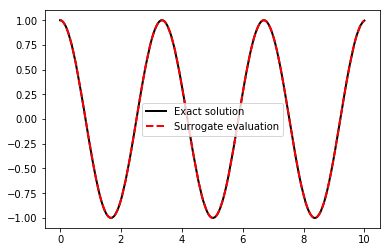

In [9]:
# Now we can load it whenever we want:

loaded_surrogate = ampPhaseDG("tutorial_surrogate/")
plt.plot(times, np.real(f(1.87654, times)), 'k', lw=2., label='Exact solution')
plt.plot(times, np.real(loaded_surrogate([1.87654])), 'r--', lw=2., label='Surrogate evaluation')
plt.legend()
plt.show()